# set-up

In [1]:
import os
os.chdir('/tscc/projects/ps-palmer/brittany/ddot')
import ddot
from netcoloc import netprop_zscore, netprop, network_colocalization, validation

In [2]:
os.chdir('/tscc/projects/ps-palmer/brittany/CrossSpeciesBMI')
#from updated_netcoloc_functions import * 
from analysis_functions import genes_per_node
from analysis_functions import get_mp_graph

In [192]:
# load required libraries
import pandas as pd
import sys
import ndex2
from getpass import getpass
import cdapsutil
import pandas as pd
import mygene
from netcoloc import validation
import netcoloc 
mg = mygene.MyGeneInfo()
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import obonet as obo
import networkx as nx
import requests
import scipy.stats as stats
import numpy as np
from adjustText import adjust_text
import matplotlib.patches as mpatches


In [4]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [5]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

NDEx credentials imported from meta file


# functions

In [6]:
UUIDs={
    'PCNet2.0':'d73d6357-e87b-11ee-9621-005056ae23aa',
    'PCNet2.1':'e9c574f4-e87a-11ee-9621-005056ae23aa',
    'PCNet2.2':'8b4b54fa-e87d-11ee-9621-005056ae23aa'
}

In [7]:
def import_seedgenes(path,pcol='P',gene_col='GENE NAME',delim='comma', cutoff=None):
    if delim=='comma':
        df=pd.read_csv(path,sep=',')
    else:
        df=pd.read_csv(path,sep='\t')
    if pcol==None:
        print('pvalue column not specified- all genes will be used')
        cutoff=None
    if cutoff=='bonferroni':
        df=df[df[pcol]<0.05/len(df)]
    elif cutoff=='FDR_05':
        df=df[df[pcol]<0.05]
    else:
        print('cutoff not defined/custom- using all genes ')
        df=df
    print(df.head())
    return(df)

In [8]:
def import_interactome(interactome_name=None, UUIDs=UUIDs,ndex_user=None, ndex_password=None,UUID=None):
    """
    Imports a gene interactome from the NDEx database and returns it as a NetworkX graph object. Optionally,
    the function allows for importing using a unique identifier (UUID) or by an interactome name.

    The function checks if the interactome name provided corresponds to a predefined dictionary of UUIDs. If it does, it
    retrieves the network using the specified credentials. If an interactome name is not provided but a UUID is,
    it retrieves the network using the provided UUID. The nodes of pcnet_v14 are relabelled by their gene name rather than ID number.

    Parameters:
    - interactome_name (str, optional): The name of the interactome as defined in the UUIDs dictionary. If not provided
      but a UUID is, the interactome associated with the UUID is imported instead.
    - ndex_user (str, optional): The NDEx account username for accessing private networks.
    - ndex_password (str, optional): The NDEx account password for accessing private networks.
    - UUID (str, optional): A specific UUID to directly download an interactome from NDEx if the interactome name is not used.

    Returns:
    networkx.Graph: A graph object representing the interactome. Nodes and edges represent genes and their interactions, respectively.

    Notes:
    - The function uses the NDEx2 Python client and requires Internet access to NDEx's servers.
    - Depending on the access rights of the NDEx account, private or public interactomes can be retrieved.
    - The function prints the number of nodes and edges of the imported graph for diagnostic purposes.

    Raises:
    - ValueError: If neither an interactome name nor a UUID is provided.
    """    
    interactome_uuid=UUIDs[interactome_name]
    print(interactome_name)
    ndex_server='public.ndexbio.org'
    #import network based on provided interactome key
    if (interactome_name in UUIDs.keys()):
        graph = ndex2.create_nice_cx_from_server(
                    ndex_server, 
                    username=ndex_user, 
                    password=ndex_password, 
                    uuid=interactome_uuid
                ).to_networkx()
        if (interactome_name=='pcnet_v14'):
            graph=nx.relabel_nodes(graph, nx.get_node_attributes(graph, 'HGNC Symbol'))
        # print out interactome num nodes and edges for diagnostic purposes
        print('number of nodes:')
        print(len(graph.nodes))
        print('\nnumber of edges:')
        print(len(graph.edges))
        return(graph)
    elif(interactome_name==None & UUID!=None):
        print('using novel UUID. For UUIDs used in this study, see UUID_dict')
        graph = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=UUID
        ).to_networkx()
        # print out interactome num nodes and edges for diagnostic purposes
        print('number of nodes:')
        print(len(graph.nodes))
        print('\nnumber of edges:')
        print(len(graph.edges))
        return(graph)
    else:
        print('UUID/interactome name not provided- please provide either to import interactome.')

In [9]:
def import_MPO_description(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology'):
    """
    Function to parse and load mouse phenotype ontology, using DDOT's ontology module
    modified from NetColoc

    :param url: URL containing MPO ontology file
    :type url: str
    :return: MPO parsed using DDOT
    :rtype: :py:class:`pd.DataFrame`
    """

    # download the mammalian phenotype ontology, parse with ddot
    r = requests.get(url,allow_redirects=True)
    open('MPheno_OBO.ontology','wb').write(r.content)

    ddot.parse_obo('MPheno_OBO.ontology',
                   'parsed_mp.txt',
                  'id2name_mp.txt',
                  'id2namespace_mp.txt',
                  'altID_mp.txt')


    MP2desc = pd.read_csv('id2name_mp.txt',sep='\t',
                          names=['MP','description'],index_col='MP')

    MP2desc=MP2desc.loc[MP2desc.index.dropna()] # drop NAN from index
    print(len(MP2desc))
    return(MP2desc)

In [10]:
def calculate_enrichment(t, coloc_dict_cat, k,sub='net',total='graph',verbose=True):
    
    # Extract the genes associated with the parent term

    # Calculate values for the contingency table
    M = len(coloc_dict_cat[total])  # Population size: genes in PCNet annotated in the GWAS catalog
    n = len(coloc_dict_cat[total].intersection(t))  # Genes in PCNet annotated for the trait of interest
    N = len(coloc_dict_cat[sub])  # Genes in the network annotated in the GWAS catalog
    x = len(coloc_dict_cat[sub].intersection(t))  # Genes in network annotated for the trait of interest

    # Build contingency table
    contingency_table = [
        [x, N - x],
        [n - x, M - N - (n - x)]
    ]
    # Perform Fisher's exact test
    odds_ratio, p_intersect = stats.fisher_exact(contingency_table, alternative='greater')
    gene_list=t.intersection(coloc_dict_cat[sub])
    p_value_hypergeom = stats.hypergeom.sf(x-1, M, n, N)
    
    try:

        se = np.sqrt(1/x + 1/(N-x) + 1/(n-x) + 1/(M - N - (n - x)))
        # Calculate the log odds ratio
        #log_or = np.log(odds_ratio)
        # Calculate the 95% confidence intervals for log odds ratio
        #lower_log_or = log_or - 1.96 * se_log_or
        #upper_log_or = log_or + 1.96 * se_log_or
        # Convert to odds ratio scale
        #lower_ci = np.exp(lower_log_or)
        #upper_ci = np.exp(upper_log_or)
    except ZeroDivisionError:
        se=None
    #else:
    #    lower_ci=None
    #    upper_ci=None


    # Create the results dictionary
    if (verbose):
        print(f"Enrichment of network nodes in genes in the GWAS catalog annotated for {k}: p={p_intersect}")
        print(f'Enrichment calcualted using hypergeom.sf for {k}: p={p_value_hypergeom}')
        print(f"Odds ratio: OD={odds_ratio}")
        print(f"Number of annotated genes in {total}: {len(t.intersection(coloc_dict_cat[total]))}")
        print(f"Number of annotated genes in {sub}: {len(t.intersection(coloc_dict_cat[sub]))}\n")

    return  odds_ratio, se, p_intersect, gene_list

In [64]:
def recurse_enrichment(par,graph,id_to_name, name_to_id,mgi_df,coloc_dict_cat,sub_community,whole_community,depth,verbose,enr_concat=[]):
    enr_tbl=pd.DataFrame(columns=['trait','parent_trait','network_genes','odds_ratio','log_se_or','p_intersect'])

    print(f"analyzing structure depth={depth}")#
    '''
    this code was written like this for the following reason- If you just started with the top of the heirarchy's single trait
    this would be unnecessary- HOWEVER, I wanted to be able to input a starting list of parent terms, as opposed to a singular term, mostly because of the EFO.
    so this takes the list of parent terms- then after that it goes through the structure following the standard way. 
    if you did it the other way, you would just want to use the else statement part of this code.
    '''
    if (depth==0):
        
        for p in par:
            #get all children terms
            children=return_descendents_name(graph,id_to_name, name_to_id[p])
            #get all genes annotated for children terms 
            t=set(mgi_df[mgi_df['MP'].isin([name_to_id[x] for x in children])]['human_ortholog'].dropna())
            odds_ratio, log_se_or, p_intersect, gene_list= calculate_enrichment(t,coloc_dict_cat,p,sub_community,whole_community,verbose)
            if (len(gene_list)>0):
                enr_tbl = pd.concat([pd.DataFrame([[p, 'mammalian phenotype', gene_list, odds_ratio, log_se_or, p_intersect]], columns=enr_tbl.columns), enr_tbl], ignore_index=True)
    else:
       for p in par:
            #select parent term
            #get all children terms (not all descendents, just first level children)- loop over
            for c in list(map(lambda x: id_to_name[x],list(graph.predecessors(name_to_id[p])))):
                # get all grand children- use all terms as subterm
                children=return_descendents_name(graph,id_to_name, name_to_id[c])
                t=set(mgi_df[mgi_df['MP'].isin([name_to_id[x] for x in children])]['human_ortholog'].dropna())
                odds_ratio, log_se_or, p_intersect, gene_list= calculate_enrichment(t,coloc_dict_cat,c,sub_community,whole_community,verbose)
                if (len(gene_list)>0):
                    enr_tbl = pd.concat([pd.DataFrame([[c, p, gene_list, odds_ratio, log_se_or, p_intersect]], columns=enr_tbl.columns), enr_tbl], ignore_index=True)
             
    enr_tbl['depth']=depth
    children=set(enr_tbl['trait'])
    if enr_concat is None:
        enr_concat = pd.DataFrame(columns=['trait', 'parent_trait', 'network_genes', 'odds_ratio', 'log_se_or', 'p_intersect', 'depth'])
    if ~(enr_tbl.empty):
        enr_concat = pd.concat([enr_concat, enr_tbl])
    
    print(f"\tlength of enrichment table={len(enr_tbl)}")
    print(f"\tlength of concatenated enrichment table={len(enr_concat)}")
    print(f"\tlength of children={len(children)}")
    if (len(children)!=0):
        return recurse_enrichment(children,graph,id_to_name, name_to_id,mgi_df,coloc_dict_cat,sub_community,whole_community,depth+1,verbose,enr_concat)
    else:
        print('returning concatenated enrichment table')
        print(enr_concat.head())
        return enr_concat

In [11]:
#return list set of traits in  ontology including parent- reported by name
def return_descendents_name(graph,id_to_name, term):
    l=list(sorted(id_to_name[subterm] for subterm in nx.ancestors(graph, term))) #descendents get subterms- not sure why but I tested it and OBONET says so as well
    l.append(id_to_name[term])
    return list(set(l))

In [12]:
#return list set of traits in  ontology including parent- reported by name
def return_ancestors_name(graph,id_to_name, term):
    print('getting ancestors for '+term+' : '+id_to_name[term])
    l=list((id_to_name[supterm] for supterm in nx.descendants(graph, term))) #descendents get superterms- not sure why
    #l.append(id_to_name[term])
    return list(set(l))

# Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [13]:
interactome_name='PCNet2.0'

In [14]:
graph=import_interactome(interactome_name)

PCNet2.0
number of nodes:
19267

number of edges:
3852119


In [15]:
all_nodes=list(graph.nodes())

# import NPS scores and seed genes

In [103]:
mag_dir='magma/seed_genes/'
file_dict={
    'loco':mag_dir+'loco_win10_annot.tsv',
    'loco_gsem':mag_dir+'loco_gsem_annot.tsv',
    'ext_munged':mag_dir+'ext_munged_annot.tsv',
    'ext':mag_dir+'ext_orig_annot.tsv',
    'ref':'/tscc/projects/ps-palmer/brittany/magma_v1/NCBI38/NCBI38.gene.loc',  
}

In [17]:
seed_dict={}

In [181]:
ref=pd.read_csv(file_dict['ref'],sep='\t',header=None)

In [18]:
loco=pd.read_csv(file_dict['loco'],sep='\t')
loco_bonf_cut=2.6389402016150313e-06 #calculated in define_seed_genes_orthologs- from raw magma results before adding in ortholog info
seed_dict['loco_FDR']=(set(loco[loco['Q']<0.05]['HM_ORTHO']))
seed_dict['loco_bonf']=(set(loco[loco['P']<loco_bonf_cut]['HM_ORTHO']))

In [19]:
#locomotor- gsem common factor
loco_gsem=pd.read_csv(file_dict['loco_gsem'],sep='\t')
loco_gsem_bonf_cut=2.650129856362962e-06 #calculated in define_seed_genes_orthologs- from raw magma results before adding in ortholog info
seed_dict['loco_gsem_FDR']=(set(loco_gsem[loco_gsem['Q']<0.05]['HM_ORTHO']))
seed_dict['loco_gsem_bonf']=(set(loco_gsem[loco_gsem['P']<loco_gsem_bonf_cut]['HM_ORTHO']))

In [20]:
ext=pd.read_csv(file_dict['ext'],sep='\t')
ext_bonf_cut=0.05/len(ext) # no ortholog adding, so can calculate from this table
seed_dict['ext_FDR']=(set(ext[ext['Q']<0.05]['GENE']))
seed_dict['ext_bonf']=(set(ext[ext['P']<ext_bonf_cut]['GENE']))
seed_dict['ext_top500']=set(ext[(ext['GENE'].isin(all_nodes))].nsmallest(500,'P')['GENE'])

In [ ]:
pd.read_csv()

In [100]:
ext

,ID,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,Q
0,105378580,LOC105378580,1,793398,815130,2,1,1492085,1.269700,0.102100,0.214091
1,148398,SAMD11,1,915741,954581,60,6,1492085,-0.920460,0.821330,0.864259
2,26155,NOC2L,1,934203,969299,23,2,1492085,0.053753,0.478570,0.603460
3,339451,KLHL17,1,949952,975720,10,1,1492085,0.542700,0.293670,0.437381
4,84069,PLEKHN1,1,956497,985108,3,1,1492085,1.918900,0.027500,0.084303
...,...,...,...,...,...,...,...,...,...,...,...
18511,105373099,LOC105373099,22,50596999,50620205,63,14,1492085,2.847000,0.002207,0.012196
18512,410,ARSA,22,50612754,50638173,74,12,1492085,1.106300,0.134300,0.257876
18513,85358,SHANK3,22,50664642,50743212,87,12,1492085,1.232000,0.108970,0.223740
18514,49,ACR,22,50728224,50755299,13,3,1492085,1.734600,0.041403,0.112826


In [21]:
'''ext=pd.read_csv(file_dict['ext'],sep='\t')
ext_bonf_cut=0.05/len(ext) # no ortholog adding, so can calculate from this table
seed_dict['ext_munged_FDR']=(set(ext[ext['Q']<0.05]['GENE']))
seed_dict['ext_munged_bonf']=(set(ext[ext['P']<ext_bonf_cut]['GENE']))'''

"ext=pd.read_csv(file_dict['ext'],sep='\t')\next_bonf_cut=0.05/len(ext) # no ortholog adding, so can calculate from this table\nseed_dict['ext_munged_FDR']=(set(ext[ext['Q']<0.05]['GENE']))\nseed_dict['ext_munged_bonf']=(set(ext[ext['P']<ext_bonf_cut]['GENE']))"

In [22]:
seed_dict.keys()

dict_keys(['loco_FDR', 'loco_bonf', 'loco_gsem_FDR', 'loco_gsem_bonf', 'ext_FDR', 'ext_bonf', 'ext_top500'])

In [23]:
NPS_dict={}
for k in seed_dict.keys():
    for u in UUIDs.keys():
        p=('network_scores/'+k+'_'+u+'_zscore.tsv')
        if os.path.isfile(p):
            t=pd.read_csv('network_scores/'+k+'_'+u+'_zscore.tsv',header=None, sep='\t')
            t.index=t[0]
            t=t.drop(columns=[0])
            t=t[1].squeeze()
            t = pd.DataFrame({'z':t})
            NPS_dict[k+'_'+u]=t

In [24]:
NPS_dict_series={}
for k in seed_dict.keys():
    for u in UUIDs.keys():
        p=('network_scores/'+k+'_'+u+'_zscore.tsv')
        if os.path.isfile(p):
            t=pd.read_csv('network_scores/'+k+'_'+u+'_zscore.tsv',header=None, sep='\t')
            t.index=t[0]
            t=t.drop(columns=[0])
            #t=t[1].squeeze()
            #t = pd.DataFrame({'z':t})
            NPS_dict_series[k+'_'+u]=t

In [25]:
NPS_dict.keys()

dict_keys(['loco_FDR_PCNet2.0', 'loco_FDR_PCNet2.2', 'loco_bonf_PCNet2.0', 'loco_bonf_PCNet2.2', 'loco_gsem_FDR_PCNet2.0', 'loco_gsem_FDR_PCNet2.1', 'loco_gsem_FDR_PCNet2.2', 'loco_gsem_bonf_PCNet2.0', 'loco_gsem_bonf_PCNet2.1', 'loco_gsem_bonf_PCNet2.2', 'ext_FDR_PCNet2.0', 'ext_FDR_PCNet2.2', 'ext_bonf_PCNet2.0', 'ext_bonf_PCNet2.2', 'ext_top500_PCNet2.0', 'ext_top500_PCNet2.2'])

# choose dataset for analysis- put gene lists into dictionary

In [26]:
#modify for cutoffs
cut_single=1.5
cut_comb=3

In [160]:
#modify for correct genesets
cut_r= 'FDR'
cut_h='top500'
#cut_h=None
trait_r='loco_gsem'
trait_h='ext'

#labels
if cut_h==None:
    label_h=trait_h
else:
    label_h=trait_h+'_'+cut_h
if cut_r==None:
    label_r=trait_r
else:
    label_r=trait_r+'_'+cut_r
#seed genes
seed_r=seed_dict[label_r]
seed_h=seed_dict[label_h]
#NPS scores
NPS_r=NPS_dict[label_r+'_'+interactome_name]
NPS_h=NPS_dict[label_h+'_'+interactome_name]

In [161]:
NPS_r.merge(NPS_h)
NPS = NPS_h.join(NPS_r, lsuffix="h", rsuffix="r")
NPS = NPS.assign(zhr=NPS.zh * NPS.zr)

In [182]:
coloc_dict={
    'seed_r':seed_r,
    'seed_h':seed_h,
    'seed_hr':list(set(seed_r).intersection(seed_h)),
    'net':list(NPS[(NPS.zh>cut_single)&(NPS.zr>cut_single)&(NPS.zhr>cut_comb)].index),
    'graph':all_nodes,
    'magma_hm_ref':set(ref[5])
}

In [180]:
seed_dict.keys()

dict_keys(['loco_FDR', 'loco_bonf', 'loco_gsem_FDR', 'loco_gsem_bonf', 'ext_FDR', 'ext_bonf', 'ext_top500', 'ref_hm_magma'])

In [185]:
# modify for which groups will be used for enrichment analysis. 
#sub_community is the community being tested for enrichment (i.e. the ext-loco network, 'net')
#whole_community is the greater pool of genes to test against (i.e. PCNET ('graph'))
#must be keys from coloc_dict
sub_community='seed_h'
whole_community='magma_hm_ref'



# import MGI datasets

In [32]:
# load mappings between genes and mammalian phenotypes
mgi_df = validation.load_MGI_mouseKO_data()
print("Number of gene-phenotype associations:", len(mgi_df))

31 input query terms found dup hits:	[('Adam1a', 2), ('Betalinc1', 2), ('Chaserr', 2), ('Dnajb3', 2), ('Dnm3os', 2), ('Eldr', 2), ('Flicr
12674 input query terms found no hit:	['+|Cav1', '+|Cm', '+|Del(10Prmt2-Pdxk)4Yey', '+|Del(11Mpo-Chad)18Brd', '+|Del(11Rr325)1Smun', '+|De


25666
12992
12961
Number of gene-phenotype associations: 383040


In [33]:
MPO_desc=import_MPO_description()

15364


/tscc/projects/ps-palmer/brittany/ddot/ddot/Ontology.py:394: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(id2namespace).to_csv(id2namespace_file, sep='\t')


In [34]:
#import the MPO in graph format
graph = obo.read_obo('http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology')
#subset the graph to remove obsolete terms
graph=graph.subgraph(list(set(MPO_desc[~MPO_desc['description'].str.contains('obsolete')].index)))

In [35]:
#get id from name or name from ID 
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

In [36]:
#list all mammalian phenotypes
[id_to_name[x] for x in nx.ancestors(graph,'MP:0000001')]

['abnormal locomotor coordination',
 'decreased cerebellum fastigial nucleus cell number',
 'increased cystadenoma incidence',
 'absent coronary vessels',
 'decreased bone mineral density of lumbar vertebrae',
 'lordosis',
 'abnormal forebrain morphology',
 'decreased circulating fibrinogen level',
 'abnormal coronary flow rate',
 'increased foot pad temperature',
 'symblepharon',
 'abnormal hair cell mechanoelectric transduction',
 'conical molar',
 'abnormal mature B cell number',
 'increased hematopoietic stem cell proliferation',
 'abnormal olfactory nerve morphology',
 'sebaceous gland atrophy',
 'abnormal growth hormone level',
 'abnormal T-helper 1 cell differentiation',
 'abnormal decidua basalis morphology',
 'abnormal fetal derived definitive erythrocyte physiology',
 'abnormal susceptibility to infection induced morbidity/mortality',
 'decreased cardiac jelly amount',
 'decreased capillary density',
 'incomplete caudal neuropore closure',
 'abnormal bone strength',
 'abnorma

In [37]:
par=[id_to_name[x] for x in graph.predecessors('MP:0000001')]

# validate whole geneset at all depths of the GWAS catalog

In [186]:
print(f'WARNING: YOU ARE CURRENTLY ANALYZING THE ENRICHMENT OF {sub_community} RELATIVE TO {whole_community}.\nTHIS IS CALCULATED FROM {label_r}, {label_h}, AND {interactome_name}.\nIF THIS IS CORRECT, CONTINUE :)')

THIS IS CALCULATED FROM loco_gsem_FDR, ext_top500, AND PCNet2.0.
IF THIS IS CORRECT, CONTINUE :)


In [187]:
coloc_dict_cat={}
for k in coloc_dict.keys():
    coloc_dict_cat[k]=set(coloc_dict[k]).intersection(list(mgi_df['human_ortholog'].dropna()))

In [ ]:
tbl=recurse_enrichment(par,graph,id_to_name, name_to_id,mgi_df,coloc_dict_cat,sub_community,whole_community,depth=0,verbose=False,enr_concat=None)

analyzing structure depth=0
	length of enrichment table=28
	length of concatenated enrichment table=28
	length of children=28
analyzing structure depth=1
	length of enrichment table=76
	length of concatenated enrichment table=104
	length of children=76
analyzing structure depth=2
	length of enrichment table=482
	length of concatenated enrichment table=586
	length of children=460
analyzing structure depth=3
	length of enrichment table=1157
	length of concatenated enrichment table=1743
	length of children=1032
analyzing structure depth=4
	length of enrichment table=1543
	length of concatenated enrichment table=3286
	length of children=1335
analyzing structure depth=5
	length of enrichment table=1636
	length of concatenated enrichment table=4922
	length of children=1366
analyzing structure depth=6


# plot enrichment

In [89]:
colormap=plt.colormaps.get_cmap('tab20b')

## scatter plot

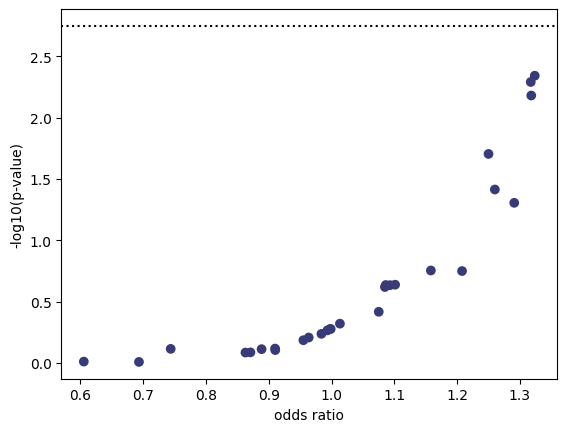

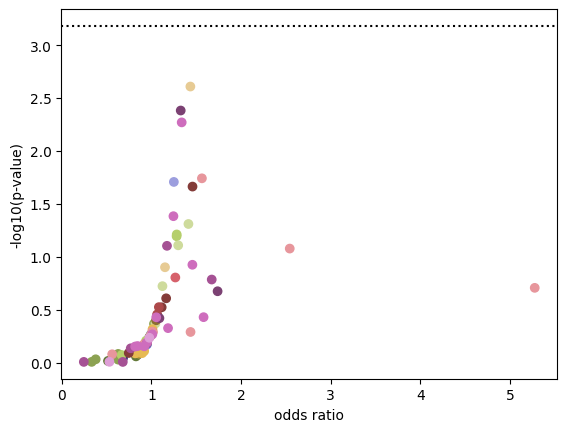

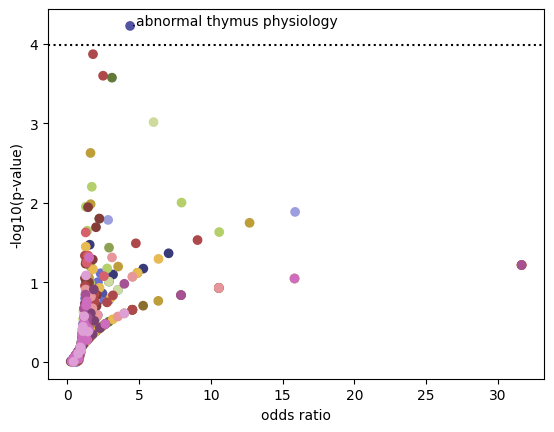

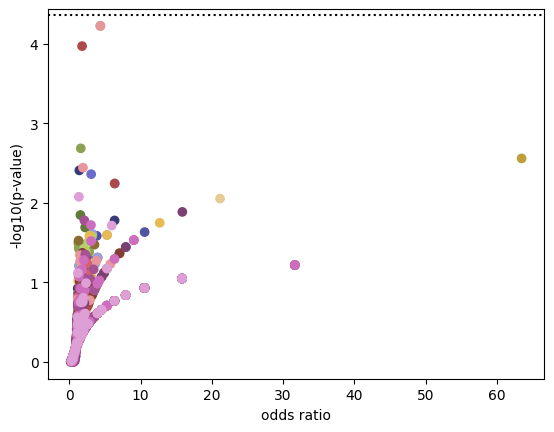

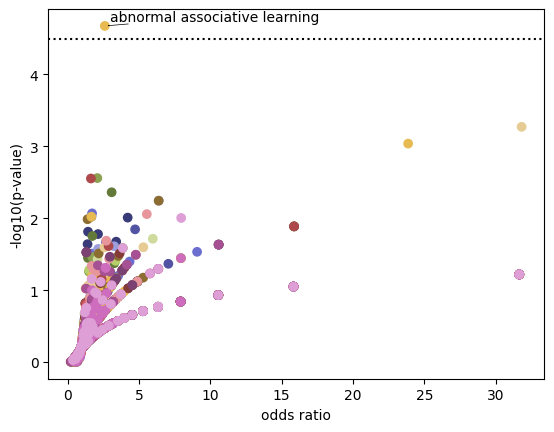

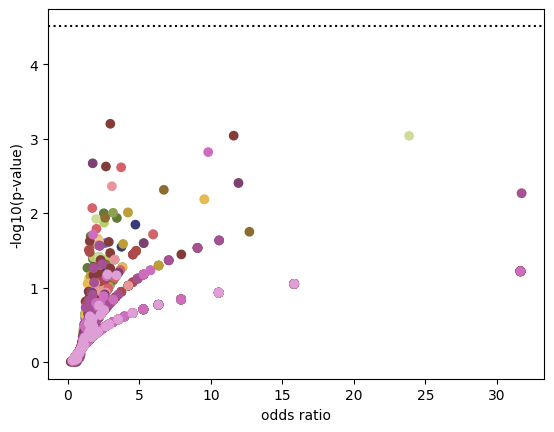

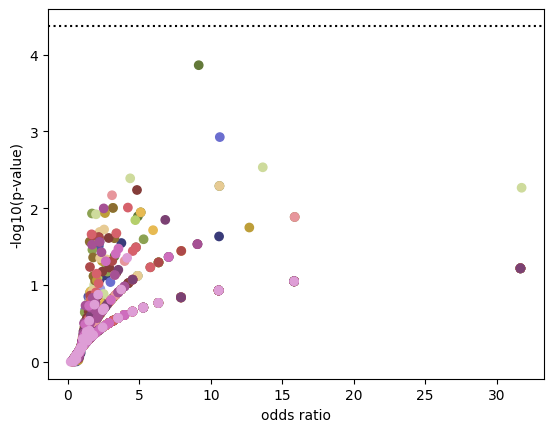

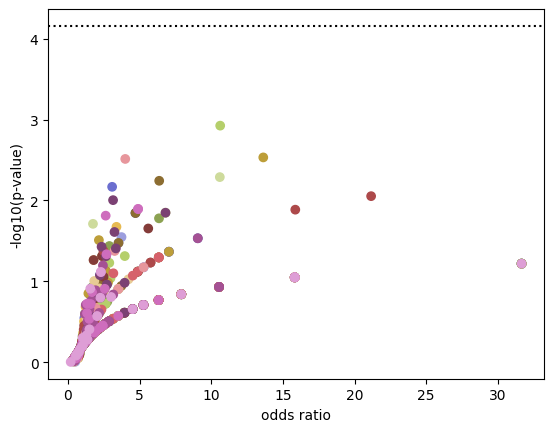

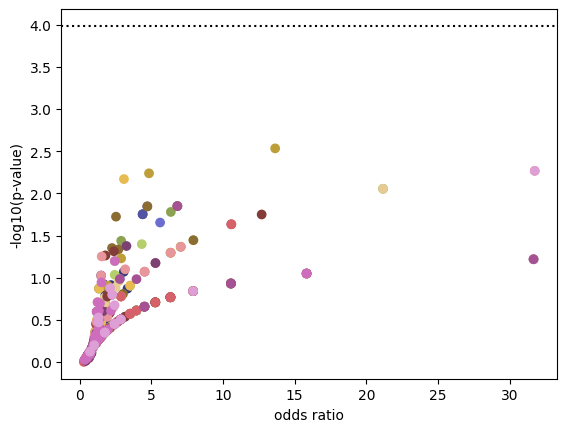

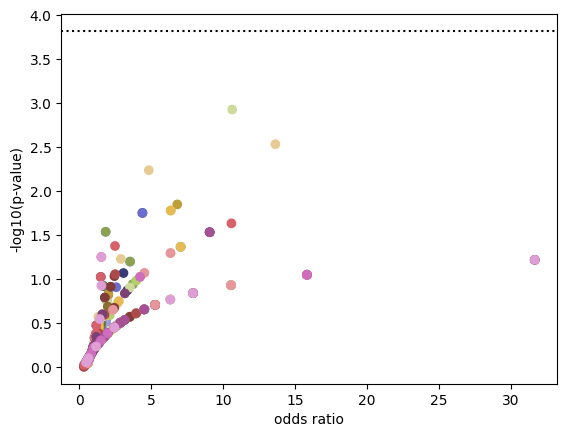

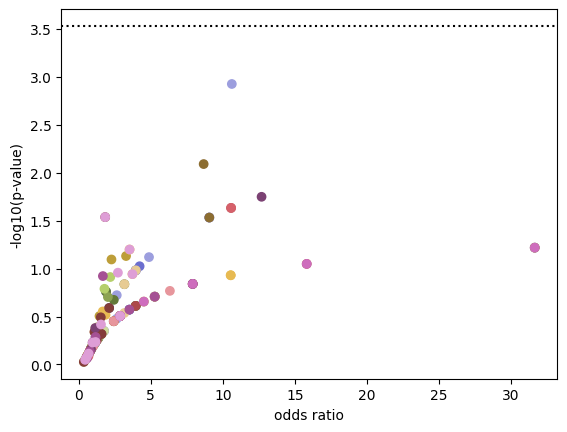

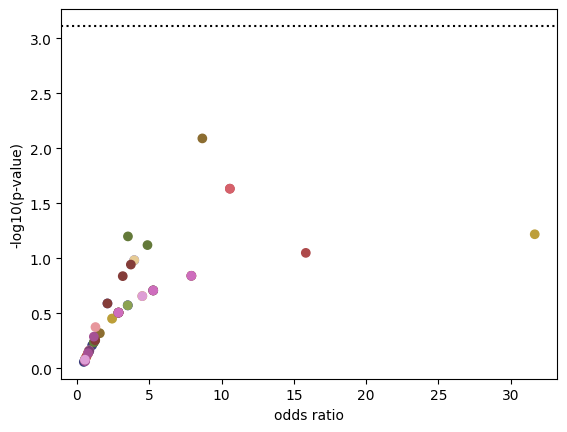

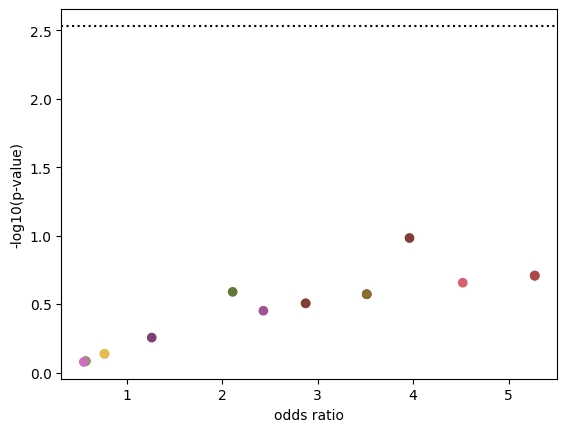

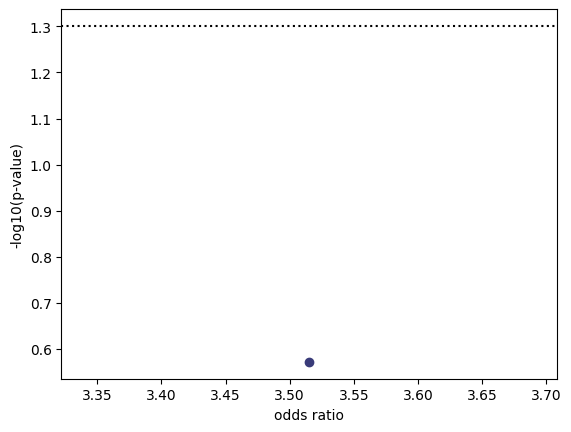

In [195]:
for d in set(tbl.depth):
    t=tbl[tbl.depth==d]
    unique_traits = t.parent_trait.unique()
    color_mapping = {trait: colormap(i / len(unique_traits)) for i, trait in enumerate(unique_traits)}
    colors = [color_mapping[trait] for trait in t.parent_trait]  # Color assignment based on parent_trait

    plt.scatter(x=t.odds_ratio,y=-np.log10(t.p_intersect),color=colors)

    plt.xlabel('odds ratio')
    plt.ylabel('-log10(p-value)')
    plt.axhline(-np.log10(0.05/len(t)),color='black',ls=':',label='bonferroni')
    texts = []
    for i in t.index:
        if (t.p_intersect[i]<(0.05/len(t))):
            texts.append(plt.annotate(t.trait[i], (t.odds_ratio[i], -np.log10(t.p_intersect[i]))))
    
    # Adjust text to avoid overlap
    adjust_text(texts, only_move={'points': 'y', 'texts': 'y'}, 
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
    
    '''
    legend_patches = [mpatches.Patch(color=color_mapping[trait], label=trait) for trait in unique_traits]
    plt.legend(handles=legend_patches, title='Parent Trait', loc='upper right',bbox_to_anchor=(2, 1))
    '''
    
    plt.show()

In [158]:
tbl[tbl.p_intersect<0.05]

,trait,parent_trait,network_genes,odds_ratio,log_se_or,p_intersect,depth
5,skeleton phenotype,mammalian phenotype,"{BICD2, TRAPPC9, CISD2, PRKACA, RTTN, PKP4, SL...",1.270237,0.120956,0.029326,0
23,renal/urinary system phenotype,mammalian phenotype,"{FGFRL1, DOCK2, DYNC2I1, GNB1L, UBTF, TRAPPC9,...",1.310300,0.14013,0.034358,0
17,lipofuscinosis,pigmentation phenotype,"{GRN, CCL2, NHLRC1}",5.741667,0.625897,0.020667,1
34,abnormal renal/urinary system morphology,renal/urinary system phenotype,"{FGFRL1, DOCK2, DYNC2I1, GNB1L, UBTF, TRAPPC9,...",1.389699,0.146916,0.017678,1
38,abnormal skeleton morphology,skeleton phenotype,"{BICD2, TRAPPC9, CISD2, PRKACA, RTTN, PKP4, SL...",1.300149,0.121811,0.019705,1
...,...,...,...,...,...,...,...
4,abnormal cementocyte morphology,abnormal cementoblast morphology,{DMP1},inf,None,0.028397,13
5,abnormal cementoblast number,abnormal cementoblast morphology,{DMP1},inf,None,0.028397,13
6,decreased cementoblast number,abnormal cementoblast number,{DMP1},inf,None,0.028397,13
0,decreased cementoblast number,abnormal cementoblast number,{DMP1},inf,None,0.028397,14


# write enrichment table

In [166]:
if (sub_community=='net'):
    tbl.to_csv(f'validation_output/MGI_enr_{label_r}_{interactome_name}_enr.csv',index=False)
elif(sub_community=='seed_r'):
    tbl.to_csv(f'validation_output/MGI_enr_seed_genes-{label_r}_{interactome_name}_enr.csv',index=False)
elif(sub_community=='seed_h'):
    tbl.to_csv(f'validation_output/MGI_enr_seed_genes-{label_h}_{interactome_name}_enr.csv',index=False)
elif(sub_community=='seed_hr'):
    tbl.to_csv(f'validation_output/MGI_enr_seed_genes-{label_r}-intersection-{label_h}_{interactome_name}_enr.csv',index=False)
else:
    tbl.to_csv(f'validation_output/MGI_enr_temp.csv',index=False)
    print('table saved as MGI_enr_temp.csv- please rename this file or you will hate yourself in 6 months')

# MPO functions from netcoloc and bmi paper

In [ ]:
# load the mammalian phenotype ontology
MPO = validation.load_MPO(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology')

In [ ]:
nx.get_node_attributes(graph,'MP:0000038')

In [ ]:
def get_MP_description(term_id, ontology=MPO):
    return ontology.node_attr.loc[term_id, "description"]

In [ ]:
#[id_to_name[x] for x in nx.ancestors(graph,'MP:0005375')]
[id_to_name[x] for x in nx.descendants(graph,'MP:0000001')]

In [ ]:
nx.ancestors(mp_graph, 'MP:0001392')

# import cross-species systems map

In [ ]:
#add network for analysis to UUIDs dictionary
UUIDs['loco_FDR_ext_top500_PCNet2.0_MAGMA'+':hidef']='4f1fc8bc-756e-11ef-ad6c-005056ae3c32'
UUIDs['loco_FDR_ext_top500_PCNet2.0_MAGMA']='76b0a7bc-494e-11ef-a7fd-005056ae23aa'

In [ ]:
netlabel='loco_FDR_ext_top500_PCNet2.0_MAGMA'

In [ ]:
network = ndex2.create_nice_cx_from_server(server='public.ndexbio.org',username= ndex_user,password=ndex_password, uuid=UUIDs[netlabel])

In [ ]:
system = ndex2.create_nice_cx_from_server(server='public.ndexbio.org',username= ndex_user,password=ndex_password, uuid=UUIDs[netlabel+':hidef'])

In [ ]:
system = system.to_networkx(mode='default')
system

sys_nodes = system.nodes()

# print the number of nodes and edges in the hierarchy for diagnostic purposes
print('Number of nodes:', len(system.nodes()))

print('\nNumber of edges:', len(system.edges()))

In [ ]:
# add node attributes to dataframe for easier access
hier_df = pd.DataFrame.from_dict(dict(system.nodes(data=True)), orient='index')
hier_df['system_ID']=hier_df.index.tolist()
# some columns are not the right type
hier_df['CD_MemberList_Size']=[int(x) for x in hier_df['CD_MemberList_Size'].tolist()]
hier_df['HiDeF_persistence']=[int(x) for x in hier_df['HiDeF_persistence'].tolist()]
hier_df.head()

## validate parent node in neuro-related communities

In [ ]:
# find terms related to brain
# ---- modify this part as needed for your project -----
MP_focal_brain_list = []
for t in MPO.node_attr.index.tolist():
    descr_temp = MPO.node_attr.loc[t]['description']
    if descr_temp.find('nervous')>-1:
        MP_focal_brain_list.append(t)
    elif descr_temp.find('neuron')>-1:
        MP_focal_brain_list.append(t)
    elif descr_temp.find('synapt')>-1:
        MP_focal_brain_list.append(t)
        
print("Number of brain phenotypes", len(MP_focal_brain_list))
print("Example brain phenotypes:")
print("\n".join([mp+" - "+get_MP_description(mp) for mp in MP_focal_brain_list[0:10]]))

In [ ]:
# add a negative control phenotype: abnormal innate immunity: MP:0002419
# negative controls are tough here because we're dealing with development, which impacts almost everything.
MP_focal_list = MP_focal_brain_list
root_KO_brain_df=validation.MPO_enrichment_root(hier_df,MPO,mgi_df,MP_focal_list,graph,verbose=True)

In [ ]:
root_KO_brain_df

In [ ]:
root_KO_brain_df.to_csv('validation_output/parent_node_hm_rn_enr_MGI_neuro.csv',index=False)

## validate parent node in locomotor-related communities

In [ ]:
# find terms related to brain
# ---- modify this part as needed for your project -----
MP_focal_loco_list = []
for t in MPO.node_attr.index.tolist():
    descr_temp = MPO.node_attr.loc[t]['description']
    if descr_temp.find('locomotor')>-1:
        MP_focal_loco_list.append(t)
        
print("Number of movement phenotypes", len(MP_focal_loco_list))
print("Example locomotor phenotypes:")
print("\n".join([mp+" - "+get_MP_description(mp) for mp in MP_focal_loco_list]))

In [ ]:
MP:0002066

In [ ]:
# add a negative control phenotype: abnormal innate immunity: MP:0002419
# negative controls are tough here because we're dealing with development, which impacts almost everything.
MP_focal_list = MP_focal_brain_list
root_KO_brain_df=validation.MPO_enrichment_root(hier_df,MPO,mgi_df,MP_focal_list,graph,verbose=True)

In [ ]:
root_KO_brain_df

In [ ]:
root_KO_brain_df.to_csv('validation_output/parent_node_hm_rn_enr_MGI_neuro.csv',index=False)